In [1]:
import os
import random

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import tensorflow.keras.backend as K

import tensorflow as tf

In [2]:
import pandas as pd, numpy as np
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


# データの読み込み

In [20]:
all_image_paths = files_train
all_image_labels = df_train.class_num

files_train = tf.io.gfile.glob(['./train_images/{}'.format(x) for x in df_train.id])
labels_train = [int(x) for x in df_train.class_num]

NameError: name 'files_train' is not defined

In [21]:
df_train = pd.read_csv("train_images.csv")
df_test = pd.read_csv("test_images.csv")
df = pd.concat([df_train, df_test]).reset_index(drop = True)

df_image_id = df.id
df_class = df.class_num

In [22]:
df = pd.concat([df_train, df_test]).reset_index(drop = True)

# 各種設定

In [23]:
DEVICE = "TPU" #or "GPU"

# USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
SEED = 42

# NUMBER OF FOLDS. USE 3, 5, OR 15 
FOLDS = 5

# WHICH IMAGE SIZES TO LOAD EACH FOLD
# CHOOSE 128, 192, 256, 384, 512, 768 
IMG_SIZES = [384,384,384,384,384]

# BATCH SIZE AND EPOCHS
BATCH_SIZES = [32]*FOLDS
EPOCHS = [12]*FOLDS

# WHICH EFFICIENTNET B? TO USE
EFF_NETS = [6,6,6,6,6]

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = [1/FOLDS]*FOLDS

# TEST TIME AUGMENTATION STEPS
TTA = 11

In [24]:
DATADIR_TRAIN = "./train_images/"
DATADIR_TEST = "./test_images/"

In [25]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    
# AUTOTUNEはGPUの処理とCPUの処理の配分を動的に設定してくれるパラメータ
AUTOTUNE     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Could not connect to TPU
Using default strategy for CPU and single GPU
Num GPUs Available:  0
REPLICAS: 1


In [26]:
from albumentations.core.transforms_interface import ImageOnlyTransform

def resize_square(img):
    """長辺のサイズで正方形の画像に"""
    l=max(img.shape[:2])
    
    h,w = img.shape[:2]
    hm = (l-h)//2
    wm = (l-w)//2
    return cv2.copyMakeBorder(img,
                            hm,
                            hm+(l-h)%2,
                            wm,
                            wm+(l-w)%2,
                            cv2.BORDER_CONSTANT,
                            value=0)

In [27]:
class CropLemon(ImageOnlyTransform):
    """レモンが写っている部分をcrop"""

    def __init__(self, margin=10, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.margin = margin

    def get_box(self, img):
        """ 中央に近い黄色い領域を見つける """
        h, s, v = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2HSV))

        # h,v のしきい値で crop
        _, img_hcrop = cv2.threshold(h, 0, 40, cv2.THRESH_BINARY)
        _, img_vcrop = cv2.threshold(v, v.mean(), 255, cv2.THRESH_BINARY)
        th_img = (img_hcrop * (img_vcrop / 255)).astype(np.uint8)

        contours, hierarchy = \
            cv2.findContours(th_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        # サイズの大きいものだけ選択
        contours = [c for c in contours if cv2.contourArea(c) > 10000]
        if not contours: return None

        # 中央に近いものを選択
        center = np.array([img.shape[1] / 2, img.shape[0] / 2])  # w, h
        min_contour = None
        min_dist = 1e10

        for c in contours:
            tmp = np.array(c).reshape(-1, 2)
            m = tmp.mean(axis=0)
            dist = sum((center - m) ** 2)
            if dist < min_dist:
                min_contour = tmp
                min_dist = dist

        box = [
            *(min_contour.min(axis=0) - self.margin).astype(np.int).tolist(),
            *(min_contour.max(axis=0) + self.margin).astype(np.int).tolist()]
        for i in range(4):
            if box[i] < 0: box[i] = 0
            if i % 2 == 0:
                if box[i] > img.shape[1]: box[i] = img.shape[1]
            else:
                if box[i] > img.shape[0]: box[i] = img.shape[0]

        return box  # left, top, right, bottom

    def apply(self, image, **params):
        image = image.copy()
        box = self.get_box(image)
        crop_img = None
        if not box or (box[3] - box[1] < 50 or box[2] - box[0] < 50):
            pass
        else:
            try:
                crop_img = image[box[1]:box[3], box[0]:box[2]]
            except:
                pass
        if crop_img is None:
            crop_img = image[40:, 10:-20]
        return resize_square(crop_img)

    def get_transform_init_args_names(self):
        return ("margin",)

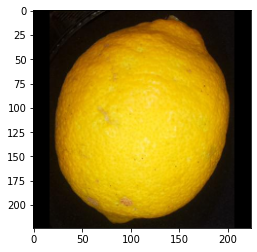

In [28]:
img = cv2.imread('train_images/train_0300.jpg')
img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
crop_img = CropLemon()(image=img)['image']
crop_img = cv2.resize(crop_img, (224, 224)) 
plt.imshow(crop_img)

In [122]:
def get_file(path1, path2, files, img_arrays=[], labels=[]):
    num = 1
    ids = files["id"]
    classes = files.class_num
    for file in ids:
        if num <= 1102:
            print("{}/{}".format(num, len(df_image_id)))
            img = cv2.imread(DATADIR_TRAIN+file)
            img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            crop_img = CropLemon()(image=img)['image']
            img_array = cv2.resize(crop_img, (224, 224))  # 画像のリサイズ
            img_arrays.append(img_array)
            num += 1
        elif num > 1102:
            print("{}/{}".format(num, len(df_image_id)))
            img = cv2.imread(DATADIR_TEST+file)
            img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            crop_img = CropLemon()(image=img)['image']
            img_array = cv2.resize(crop_img, (224, 224))  # 画像のリサイズ
            img_arrays.append(img_array)
            num += 1
            
    for label in classes:
        labels.append(label)
    
    return img_arrays, labels

In [123]:
img_arrays, labels = get_file(DATADIR_TRAIN, DATADIR_TEST, df)

1/2753
2/2753
3/2753
4/2753
5/2753
6/2753
7/2753
8/2753
9/2753
10/2753
11/2753
12/2753
13/2753
14/2753
15/2753
16/2753
17/2753
18/2753
19/2753
20/2753
21/2753
22/2753
23/2753
24/2753
25/2753
26/2753
27/2753
28/2753
29/2753
30/2753
31/2753
32/2753
33/2753
34/2753
35/2753
36/2753
37/2753
38/2753
39/2753
40/2753
41/2753
42/2753
43/2753
44/2753
45/2753
46/2753
47/2753
48/2753
49/2753
50/2753
51/2753
52/2753
53/2753
54/2753
55/2753
56/2753
57/2753
58/2753
59/2753
60/2753
61/2753
62/2753
63/2753
64/2753
65/2753
66/2753
67/2753
68/2753
69/2753
70/2753
71/2753
72/2753
73/2753
74/2753
75/2753
76/2753
77/2753
78/2753
79/2753
80/2753
81/2753
82/2753
83/2753
84/2753
85/2753
86/2753
87/2753
88/2753
89/2753
90/2753
91/2753
92/2753
93/2753
94/2753
95/2753
96/2753
97/2753
98/2753
99/2753
100/2753
101/2753
102/2753
103/2753
104/2753
105/2753
106/2753
107/2753
108/2753
109/2753
110/2753
111/2753
112/2753
113/2753
114/2753
115/2753
116/2753
117/2753
118/2753
119/2753
120/2753
121/2753
122/2753
123/2753
1

943/2753
944/2753
945/2753
946/2753
947/2753
948/2753
949/2753
950/2753
951/2753
952/2753
953/2753
954/2753
955/2753
956/2753
957/2753
958/2753
959/2753
960/2753
961/2753
962/2753
963/2753
964/2753
965/2753
966/2753
967/2753
968/2753
969/2753
970/2753
971/2753
972/2753
973/2753
974/2753
975/2753
976/2753
977/2753
978/2753
979/2753
980/2753
981/2753
982/2753
983/2753
984/2753
985/2753
986/2753
987/2753
988/2753
989/2753
990/2753
991/2753
992/2753
993/2753
994/2753
995/2753
996/2753
997/2753
998/2753
999/2753
1000/2753
1001/2753
1002/2753
1003/2753
1004/2753
1005/2753
1006/2753
1007/2753
1008/2753
1009/2753
1010/2753
1011/2753
1012/2753
1013/2753
1014/2753
1015/2753
1016/2753
1017/2753
1018/2753
1019/2753
1020/2753
1021/2753
1022/2753
1023/2753
1024/2753
1025/2753
1026/2753
1027/2753
1028/2753
1029/2753
1030/2753
1031/2753
1032/2753
1033/2753
1034/2753
1035/2753
1036/2753
1037/2753
1038/2753
1039/2753
1040/2753
1041/2753
1042/2753
1043/2753
1044/2753
1045/2753
1046/2753
1047/2753
1048/27

1781/2753
1782/2753
1783/2753
1784/2753
1785/2753
1786/2753
1787/2753
1788/2753
1789/2753
1790/2753
1791/2753
1792/2753
1793/2753
1794/2753
1795/2753
1796/2753
1797/2753
1798/2753
1799/2753
1800/2753
1801/2753
1802/2753
1803/2753
1804/2753
1805/2753
1806/2753
1807/2753
1808/2753
1809/2753
1810/2753
1811/2753
1812/2753
1813/2753
1814/2753
1815/2753
1816/2753
1817/2753
1818/2753
1819/2753
1820/2753
1821/2753
1822/2753
1823/2753
1824/2753
1825/2753
1826/2753
1827/2753
1828/2753
1829/2753
1830/2753
1831/2753
1832/2753
1833/2753
1834/2753
1835/2753
1836/2753
1837/2753
1838/2753
1839/2753
1840/2753
1841/2753
1842/2753
1843/2753
1844/2753
1845/2753
1846/2753
1847/2753
1848/2753
1849/2753
1850/2753
1851/2753
1852/2753
1853/2753
1854/2753
1855/2753
1856/2753
1857/2753
1858/2753
1859/2753
1860/2753
1861/2753
1862/2753
1863/2753
1864/2753
1865/2753
1866/2753
1867/2753
1868/2753
1869/2753
1870/2753
1871/2753
1872/2753
1873/2753
1874/2753
1875/2753
1876/2753
1877/2753
1878/2753
1879/2753
1880/2753


2614/2753
2615/2753
2616/2753
2617/2753
2618/2753
2619/2753
2620/2753
2621/2753
2622/2753
2623/2753
2624/2753
2625/2753
2626/2753
2627/2753
2628/2753
2629/2753
2630/2753
2631/2753
2632/2753
2633/2753
2634/2753
2635/2753
2636/2753
2637/2753
2638/2753
2639/2753
2640/2753
2641/2753
2642/2753
2643/2753
2644/2753
2645/2753
2646/2753
2647/2753
2648/2753
2649/2753
2650/2753
2651/2753
2652/2753
2653/2753
2654/2753
2655/2753
2656/2753
2657/2753
2658/2753
2659/2753
2660/2753
2661/2753
2662/2753
2663/2753
2664/2753
2665/2753
2666/2753
2667/2753
2668/2753
2669/2753
2670/2753
2671/2753
2672/2753
2673/2753
2674/2753
2675/2753
2676/2753
2677/2753
2678/2753
2679/2753
2680/2753
2681/2753
2682/2753
2683/2753
2684/2753
2685/2753
2686/2753
2687/2753
2688/2753
2689/2753
2690/2753
2691/2753
2692/2753
2693/2753
2694/2753
2695/2753
2696/2753
2697/2753
2698/2753
2699/2753
2700/2753
2701/2753
2702/2753
2703/2753
2704/2753
2705/2753
2706/2753
2707/2753
2708/2753
2709/2753
2710/2753
2711/2753
2712/2753
2713/2753


(<matplotlib.image.AxesImage at 0x7ff9b9b3eba8>, Text(0.5, 1.0, '2.0'))

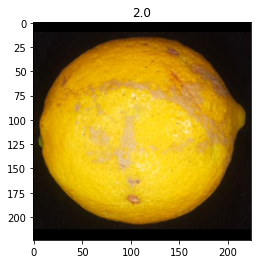

In [124]:
plt.imshow(img_arrays[30]), plt.title(labels[30])

# Tensorflowを使ったデータセットの作製

In [125]:
# 正規化
x_train = img_arrays[:1102]
x_test = img_arrays[1102:]
y_train = labels[:1102]
y_test = labels[1102:]

x_train = np.asarray(x_train) / 255.
x_test = np.asarray(x_test) / 255.
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

(<matplotlib.image.AxesImage at 0x7ff923d48d68>, Text(0.5, 1.0, '1.0'))

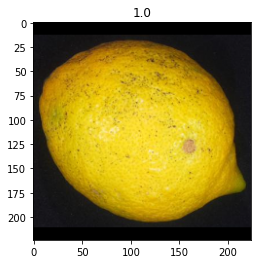

In [160]:
plt.imshow(x_train[10]), plt.title(y_train[10])

In [126]:
batch_size=32
input_size = (224, 224)

In [181]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split = 0.1, #10 for validation 
    rotation_range=360,
    zca_whitening=True,
    zca_epsilon=1e-06,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
    shear_range=0.1,
#     zoom_range=[0.5,1.0],
    #channel_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None,
    preprocessing_function=None,
    )

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.1)

In [182]:
train_generator = train_datagen.flow(x_train, 
                                               y_train, 
                                               batch_size = 32
                                              )

valid_generator = valid_datagen.flow(
                                               x_train, 
                                               y_train, 
                                               batch_size = 32)

In [183]:
batch1, batch2 = train_generator.next()

In [184]:
df_train.class_num = df_train.astype("str")

In [185]:
batch1.shape

(32, 224, 224, 3)

In [186]:
df_train["class_num"] = df_train["class_num"].astype("str")

In [187]:
batch1 = train_generator.next()

In [188]:
batch1, batch2 =  train_generator.next()

In [189]:
batch1[0].shape

(224, 224, 3)

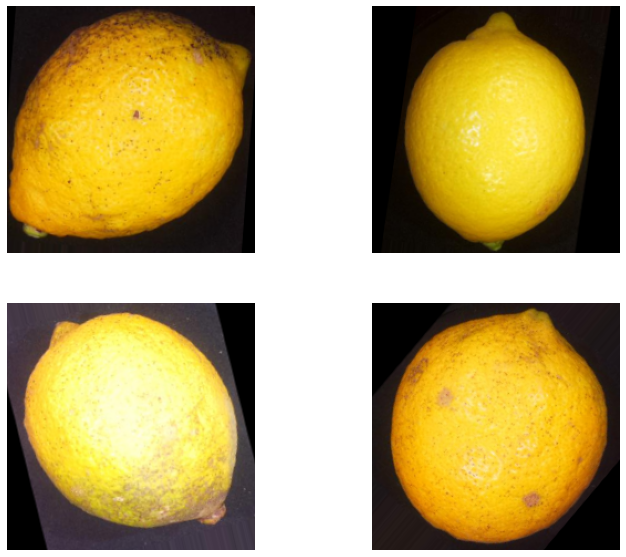

In [193]:
plt.figure(figsize=(12,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    batch1,batch2 = train_generator.next()
    image = batch1[0]
    plt.imshow(image)
    plt.axis("off")
# show the figure
plt.show()

# データセットの作製

In [138]:
y_train.shape

(1102,)

In [139]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Model

from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.utils import plot_model, to_categorical
from keras.callbacks import TensorBoard

import tensorflow as tf

In [140]:
# モデルの定義

def CNN(x_train, y_train):
    visible = Input(shape=x_train.shape[1:])
    conv1 = Conv2D(32, kernel_size=4, activation='relu')(visible)
    pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(16, kernel_size=4, activation='relu')(pool1)
    pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
    flat = Flatten()(pool2)
    hidden1 = Dense(16, activation='relu')(flat)
    output = Dense(4, activation='softmax')(hidden1)
    model = Model(inputs=visible, outputs=output)

    adam = Adam(lr=1e-3)

    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=["accuracy"])
    print(model.summary())

    return model

In [141]:
model_cnn = CNN(x_train, y_train)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 221, 221, 32)      1568      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 107, 107, 16)      8208      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 53, 53, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 44944)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)               

In [144]:
history = model_cnn.fit(train_generator,
    validation_data = valid_generator,
    epochs=20, 
    verbose=1,
    steps_per_epoch = len(df_train)*0.9//batch_size,
    validation_steps = len(df_train)*0.1//batch_size )

Epoch 1/20
30/30 [==============================] - 19s 643ms/step - loss: 0.6231 - accuracy: 0.7845 - val_loss: 0.7301 - val_accuracy: 0.7292
Epoch 2/20
30/30 [==============================] - 20s 652ms/step - loss: 0.6295 - accuracy: 0.7824 - val_loss: 0.6355 - val_accuracy: 0.8229
Epoch 3/20
30/30 [==============================] - 20s 655ms/step - loss: 0.6553 - accuracy: 0.7813 - val_loss: 0.5029 - val_accuracy: 0.8438
Epoch 4/20
30/30 [==============================] - 20s 666ms/step - loss: 0.6593 - accuracy: 0.7792 - val_loss: 0.5702 - val_accuracy: 0.8021
Epoch 5/20
30/30 [==============================] - 23s 759ms/step - loss: 0.6099 - accuracy: 0.7983 - val_loss: 0.5623 - val_accuracy: 0.8021
Epoch 6/20
30/30 [==============================] - 22s 738ms/step - loss: 0.6320 - accuracy: 0.7813 - val_loss: 0.6891 - val_accuracy: 0.6979
Epoch 7/20
30/30 [==============================] - 20s 682ms/step - loss: 0.6002 - accuracy: 0.7962 - val_loss: 0.5855 - val_accuracy: 0.8021

In [145]:
pred = model_cnn.predict(x_test)
prediction =np.argmax(pred,axis=1)
df_pred = pd.DataFrame([prediction])

In [146]:
df_pred

,0,1,2,3,4,5,6,7,8,9,...,1641,1642,1643,1644,1645,1646,1647,1648,1649,1650
0,0,3,0,3,0,1,0,1,2,0,...,0,1,1,1,0,1,2,1,0,0


In [150]:
pred_sam.head(6)

,test_0000.jpg,0
0,test_0001.jpg,3
1,test_0002.jpg,0
2,test_0003.jpg,3
3,test_0004.jpg,0
4,test_0005.jpg,0
5,test_0006.jpg,0


In [151]:
import efficientnet.tfkeras as efn

In [155]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6]

# dim: 入力 df:どのefficientnetを使用するか class_num:分類するクラスの種類
def build_model(dim=224, ef=0, class_num=4):
    inp = tf.keras.layers.Input(shape=(dim,dim,3))
    base = EFNS[ef](input_shape=(dim,dim,3),weights='imagenet',include_top=False)
    # Freeze the pretrained weights
    basetrainable = False
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    x = Dropout(0.8)(x)
    x = tf.keras.layers.Dense(class_num,activation='softmax')(x)
    model = tf.keras.Model(inputs=inp,outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [156]:
model = build_model()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 5124      
Total params: 4,054,688
Trainable params: 4,012,672
Non-trainable params: 42,016
_________________________________________________________________


In [157]:
history = model.fit(x_train, y_train, batch_size=32, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
28/28 [==============================] - 156s 6s/step - loss: 0.6015 - accuracy: 0.7582 - val_loss: 6.4772 - val_accuracy: 0.3665
Epoch 2/5
28/28 [==============================] - 153s 5s/step - loss: 0.2038 - accuracy: 0.9342 - val_loss: 3.7635 - val_accuracy: 0.4344
Epoch 3/5


KeyboardInterrupt: 